In [1]:
import numpy as np
import pandas as pd
import cv2

In [2]:
df = pd.read_csv('challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

In [3]:
df.head(10)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,Training,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,Training,255 254 255 254 254 179 122 107 95 124 149 150...


In [4]:
df[' pixels']

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name:  pixels, Length: 35887, dtype: object

In [5]:
def to_img(row):
    return np.array(row[' pixels'].split(' ')).reshape(48,48).astype('uint8')

In [6]:
df['img'] = df.apply(to_img, axis=1)

In [7]:
df['img'][0]

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ...,
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]], dtype=uint8)

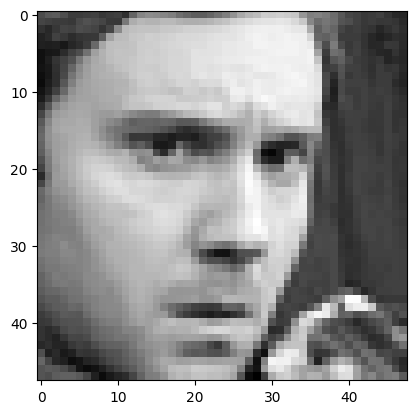

In [8]:
import matplotlib.pyplot as plt
plt.imshow(df['img'][0], cmap='gray')
plt.show()

In [9]:
from tqdm import tqdm
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

In [10]:
def prepareforANN(lanmarks):
    return np.array([[landmark.x, landmark.y, landmark.z] for landmark in lanmarks])

In [11]:
def drawalllandmark(annotated_image, result):
    for face_landmarks in result.multi_face_landmarks:
        # print('face_landmarks:', face_landmarks)
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.
            get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.
            get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.
            get_default_face_mesh_iris_connections_style())
        
    return annotated_image

In [12]:
def emotionmapping(emotion):
    if emotion == 0:
        return 'anger'
    elif emotion == 1:
        return 'disgust'
    elif emotion == 2:
        return 'fear'
    elif emotion == 3:
        return 'happy'
    elif emotion == 4:
        return 'sad'
    elif emotion == 5:
        return 'surprise'
    elif emotion == 6:
        return 'neutral'

In [13]:
def getlandmark(df):
    new_df = pd.DataFrame(columns=['usage', 'feature', 'target'])
    with mp_face_mesh.FaceMesh(static_image_mode=True,
                               max_num_faces=1,
                               refine_landmarks=True,
                               min_detection_confidence=0.5) as face_mesh:
        for data in tqdm(df[[' Usage','img', 'emotion']].values):
            # Convert the BGR image to RGB before processing.
            result = face_mesh.process(cv2.cvtColor(data[1], cv2.COLOR_GRAY2RGB))
            emotion = data[2]
            # Print and draw face mesh landmarks on the image.
            if not result.multi_face_landmarks:
                continue
            np_landmark = prepareforANN(result.multi_face_landmarks[0].landmark)
            new_df = pd.concat([new_df, pd.DataFrame([[data[0], np_landmark, emotion]], columns=['usage', 'feature', 'target'])], ignore_index=True)
            # annotated_image = cv2.cvtColor(data[1], cv2.COLOR_GRAY2RGB).copy()
            # annotated_image = drawalllandmark(annotated_image, result)
            # plt.imshow(annotated_image)
    return new_df


In [14]:
# result = getlandmark(pd.concat([df[0:10],df[29000:29010],df[-10:]]))
result = getlandmark(df)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
 35%|███▌      | 12704/35887 [02:35<04:41, 82.40it/s]

In [ ]:
result

,usage,feature,target
0,Training,"[[0.5199680328369141, 0.7789784669876099, -0.0...",0
1,Training,"[[0.5085993409156799, 0.7591274380683899, -0.1...",0
2,Training,"[[0.33950066566467285, 0.7026019096374512, -0....",2
3,Training,"[[0.5091360807418823, 0.7863333821296692, -0.0...",6
4,Training,"[[0.5136174559593201, 0.7689816951751709, -0.1...",2
5,Training,"[[0.43531954288482666, 0.8602523803710938, -0....",4
6,Training,"[[0.4482179880142212, 0.6476788520812988, -0.0...",3
7,Training,"[[0.5302619934082031, 0.7715927958488464, -0.0...",3
8,Training,"[[0.4944169819355011, 0.8042576313018799, -0.0...",2
9,PublicTest,"[[0.6867560744285583, 0.6710814237594604, -0.0...",3


In [ ]:
result['target']

0     0
1     0
2     2
3     6
4     2
5     4
6     3
7     3
8     2
9     3
10    6
11    4
12    3
13    6
14    6
15    6
16    5
17    6
18    3
19    2
20    2
21    0
22    6
23    0
24    3
25    2
Name: target, dtype: object

In [ ]:
result['usage'].value_counts()

Training       9
PrivateTest    9
PublicTest     8
Name: usage, dtype: int64

In [ ]:
train_df = result[result['usage'] == 'Training'].drop(columns='usage')
val_df = result[result['usage'] == 'PublicTest'].drop(columns='usage')
test_df = result[result['usage'] == 'PrivateTest'].drop(columns='usage')

In [ ]:
import facemeshANN

In [ ]:
model = facemeshANN.ANNClassifier(478*3, 8)
model, test_loss, correct = facemeshANN.trainmodel(model, train_df, val_df, test_df, epochs=100)

Using mps device


train_loss:None | val_loss:None | val_acc:None | test_loss:None | test_acc:None:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs : 0


 22%|██▏       | 2/9 [00:00<00:00, 40.23it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 176.77it/s]
train_loss:2.069669008255005 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:None | test_acc:None:   1%|          | 1/100 [00:00<00:08, 11.83it/s]

Epochs : 1


 12%|█▎        | 1/8 [00:00<00:00, 350.99it/s]
train_loss:2.064279079437256 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.0803751945495605 | test_acc:0.125:   2%|▏         | 2/100 [00:00<00:05, 18.20it/s]

Epochs : 2


 12%|█▎        | 1/8 [00:00<00:00, 208.37it/s]
train_loss:2.058969020843506 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.080970048904419 | test_acc:0.125:   3%|▎         | 3/100 [00:00<00:05, 18.20it/s] 

Epochs : 3


 12%|█▎        | 1/8 [00:00<00:00, 268.54it/s]
train_loss:2.0537078380584717 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.0815236568450928 | test_acc:0.125:   4%|▍         | 4/100 [00:00<00:05, 18.20it/s]

Epochs : 4


 12%|█▎        | 1/8 [00:00<00:00, 192.59it/s]
train_loss:2.0484778881073 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.08206844329834 | test_acc:0.125:   5%|▌         | 5/100 [00:00<00:05, 18.20it/s]     

Epochs : 5


 12%|█▎        | 1/8 [00:00<00:00, 120.31it/s]
train_loss:2.043325185775757 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.082606792449951 | test_acc:0.0:   6%|▌         | 6/100 [00:00<00:03, 26.63it/s]

Epochs : 6


 12%|█▎        | 1/8 [00:00<00:00, 252.02it/s]
train_loss:2.0381968021392822 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.0831356048583984 | test_acc:0.0:   7%|▋         | 7/100 [00:00<00:03, 26.63it/s]

Epochs : 7


 12%|█▎        | 1/8 [00:00<00:00, 289.88it/s]
train_loss:2.0332298278808594 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.083648681640625 | test_acc:0.0:   8%|▊         | 8/100 [00:00<00:03, 26.63it/s] 

Epochs : 8


 12%|█▎        | 1/8 [00:00<00:00, 359.69it/s]
train_loss:2.028343677520752 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.084137201309204 | test_acc:0.0:   9%|▉         | 9/100 [00:00<00:03, 26.63it/s] 

Epochs : 9


 12%|█▎        | 1/8 [00:00<00:00, 256.08it/s]
train_loss:2.0235588550567627 | val_loss:2.0817805528640747 | val_acc:0.0 | test_loss:2.084639549255371 | test_acc:0.0:  10%|█         | 10/100 [00:00<00:03, 26.63it/s]

Epochs : 10


 22%|██▏       | 2/9 [00:00<00:00, 170.07it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 523.14it/s]
train_loss:2.0187487602233887 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.084639549255371 | test_acc:0.0:  11%|█         | 11/100 [00:00<00:02, 35.01it/s]

Epochs : 11


 12%|█▎        | 1/8 [00:00<00:00, 227.48it/s]
train_loss:2.0139472484588623 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.085639238357544 | test_acc:0.0:  12%|█▏        | 12/100 [00:00<00:02, 35.01it/s]

Epochs : 12


 12%|█▎        | 1/8 [00:00<00:00, 251.65it/s]
train_loss:2.0091381072998047 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.086123466491699 | test_acc:0.0:  13%|█▎        | 13/100 [00:00<00:02, 35.01it/s]

Epochs : 13


 12%|█▎        | 1/8 [00:00<00:00, 321.33it/s]
train_loss:2.004347562789917 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.086599826812744 | test_acc:0.0:  14%|█▍        | 14/100 [00:00<00:02, 35.01it/s] 

Epochs : 14


 12%|█▎        | 1/8 [00:00<00:00, 218.01it/s]
train_loss:1.9995993375778198 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.0870747566223145 | test_acc:0.0:  15%|█▌        | 15/100 [00:00<00:02, 35.36it/s]

Epochs : 15


 12%|█▎        | 1/8 [00:00<00:00, 233.43it/s]
train_loss:1.9948567152023315 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.087554454803467 | test_acc:0.0:  16%|█▌        | 16/100 [00:00<00:02, 35.36it/s] 

Epochs : 16


 12%|█▎        | 1/8 [00:00<00:00, 318.26it/s]
train_loss:1.9900991916656494 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.0880095958709717 | test_acc:0.0:  17%|█▋        | 17/100 [00:00<00:02, 35.36it/s]

Epochs : 17


 12%|█▎        | 1/8 [00:00<00:00, 246.12it/s]
train_loss:1.9853636026382446 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.088479995727539 | test_acc:0.0:  18%|█▊        | 18/100 [00:00<00:02, 35.36it/s] 

Epochs : 18


 12%|█▎        | 1/8 [00:00<00:00, 280.57it/s]
train_loss:1.980648159980774 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.0889487266540527 | test_acc:0.0:  19%|█▉        | 19/100 [00:00<00:02, 35.36it/s]

Epochs : 19


 12%|█▎        | 1/8 [00:00<00:00, 213.72it/s]
train_loss:1.976073145866394 | val_loss:2.0927791595458984 | val_acc:0.3333333333333333 | test_loss:2.0894124507904053 | test_acc:0.0:  20%|██        | 20/100 [00:00<00:02, 35.16it/s]

Epochs : 20


 22%|██▏       | 2/9 [00:00<00:00, 171.44it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 385.06it/s]
train_loss:1.9715754985809326 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.0894124507904053 | test_acc:0.0:  21%|██        | 21/100 [00:00<00:02, 35.16it/s]

Epochs : 21


 12%|█▎        | 1/8 [00:00<00:00, 267.73it/s]
train_loss:1.967119812965393 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.0903258323669434 | test_acc:0.0:  22%|██▏       | 22/100 [00:00<00:02, 35.16it/s] 

Epochs : 22


 12%|█▎        | 1/8 [00:00<00:00, 267.75it/s]
train_loss:1.96265709400177 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.090815305709839 | test_acc:0.0:  23%|██▎       | 23/100 [00:00<00:02, 35.16it/s]  

Epochs : 23


 12%|█▎        | 1/8 [00:00<00:00, 251.91it/s]
train_loss:1.9580990076065063 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.0913045406341553 | test_acc:0.0:  24%|██▍       | 24/100 [00:00<00:02, 35.16it/s]

Epochs : 24


 12%|█▎        | 1/8 [00:00<00:00, 295.06it/s]
train_loss:1.953497052192688 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.0918009281158447 | test_acc:0.0:  25%|██▌       | 25/100 [00:00<00:02, 35.16it/s] 

Epochs : 25


 12%|█▎        | 1/8 [00:00<00:00, 116.34it/s]
train_loss:1.9488787651062012 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.0923097133636475 | test_acc:0.0:  26%|██▌       | 26/100 [00:00<00:01, 39.38it/s]

Epochs : 26


 12%|█▎        | 1/8 [00:00<00:00, 200.44it/s]
train_loss:1.9442815780639648 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.092780828475952 | test_acc:0.0:  27%|██▋       | 27/100 [00:00<00:01, 39.38it/s] 

Epochs : 27


 12%|█▎        | 1/8 [00:00<00:00, 246.43it/s]
train_loss:1.9396297931671143 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.0932888984680176 | test_acc:0.0:  28%|██▊       | 28/100 [00:00<00:01, 39.38it/s]

Epochs : 28


 12%|█▎        | 1/8 [00:00<00:00, 290.46it/s]
train_loss:1.9348902702331543 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.0938193798065186 | test_acc:0.0:  29%|██▉       | 29/100 [00:00<00:01, 39.38it/s]

Epochs : 29


 12%|█▎        | 1/8 [00:00<00:00, 307.32it/s]
train_loss:1.9302036762237549 | val_loss:2.026162564754486 | val_acc:0.3333333333333333 | test_loss:2.094315528869629 | test_acc:0.0:  30%|███       | 30/100 [00:00<00:01, 38.93it/s] 

Epochs : 30


 22%|██▏       | 2/9 [00:00<00:00, 201.61it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 516.00it/s]
train_loss:1.925459384918213 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.094315528869629 | test_acc:0.0:  31%|███       | 31/100 [00:00<00:01, 38.93it/s] 

Epochs : 31


 12%|█▎        | 1/8 [00:00<00:00, 152.03it/s]
train_loss:1.9207651615142822 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.095366954803467 | test_acc:0.0:  32%|███▏      | 32/100 [00:00<00:01, 38.93it/s]

Epochs : 32


 12%|█▎        | 1/8 [00:00<00:00, 167.65it/s]
train_loss:1.9160218238830566 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.0959157943725586 | test_acc:0.0:  33%|███▎      | 33/100 [00:00<00:01, 38.93it/s]

Epochs : 33


 12%|█▎        | 1/8 [00:00<00:00, 128.14it/s]
train_loss:1.911293864250183 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.096458911895752 | test_acc:0.0:  34%|███▍      | 34/100 [00:00<00:01, 36.35it/s]  

Epochs : 34


 12%|█▎        | 1/8 [00:00<00:00, 220.56it/s]
train_loss:1.9066200256347656 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.0970144271850586 | test_acc:0.0:  35%|███▌      | 35/100 [00:00<00:01, 36.35it/s]

Epochs : 35


 12%|█▎        | 1/8 [00:00<00:00, 286.05it/s]
train_loss:1.9020159244537354 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.097567558288574 | test_acc:0.0:  36%|███▌      | 36/100 [00:01<00:01, 36.35it/s] 

Epochs : 36


 12%|█▎        | 1/8 [00:00<00:00, 246.67it/s]
train_loss:1.8974533081054688 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.098135232925415 | test_acc:0.0:  37%|███▋      | 37/100 [00:01<00:01, 36.35it/s]

Epochs : 37


 12%|█▎        | 1/8 [00:00<00:00, 263.86it/s]
train_loss:1.8928357362747192 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.098728656768799 | test_acc:0.0:  38%|███▊      | 38/100 [00:01<00:01, 36.35it/s]

Epochs : 38


 12%|█▎        | 1/8 [00:00<00:00, 296.04it/s]
train_loss:1.8882391452789307 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.099285840988159 | test_acc:0.0:  39%|███▉      | 39/100 [00:01<00:01, 40.01it/s]

Epochs : 39


 12%|█▎        | 1/8 [00:00<00:00, 247.03it/s]
train_loss:1.8836791515350342 | val_loss:1.998602569103241 | val_acc:0.3333333333333333 | test_loss:2.099867820739746 | test_acc:0.0:  40%|████      | 40/100 [00:01<00:01, 40.01it/s]

Epochs : 40


 22%|██▏       | 2/9 [00:00<00:00, 184.81it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 282.41it/s]
train_loss:1.879113793373108 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.099867820739746 | test_acc:0.0:  41%|████      | 41/100 [00:01<00:01, 40.01it/s] 

Epochs : 41


 12%|█▎        | 1/8 [00:00<00:00, 306.00it/s]
train_loss:1.874556303024292 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.1010773181915283 | test_acc:0.0:  42%|████▏     | 42/100 [00:01<00:01, 40.01it/s]

Epochs : 42


 12%|█▎        | 1/8 [00:00<00:00, 260.16it/s]
train_loss:1.8699572086334229 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.101665496826172 | test_acc:0.0:  43%|████▎     | 43/100 [00:01<00:01, 40.01it/s]

Epochs : 43


 12%|█▎        | 1/8 [00:00<00:00, 223.52it/s]
train_loss:1.8653403520584106 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.1022884845733643 | test_acc:0.0:  44%|████▍     | 44/100 [00:01<00:01, 38.47it/s]

Epochs : 44


 12%|█▎        | 1/8 [00:00<00:00, 260.76it/s]
train_loss:1.8607035875320435 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.102907419204712 | test_acc:0.0:  45%|████▌     | 45/100 [00:01<00:01, 38.47it/s] 

Epochs : 45


 12%|█▎        | 1/8 [00:00<00:00, 353.47it/s]
train_loss:1.855971336364746 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.1035103797912598 | test_acc:0.0:  46%|████▌     | 46/100 [00:01<00:01, 38.47it/s]

Epochs : 46


 12%|█▎        | 1/8 [00:00<00:00, 136.89it/s]
train_loss:1.8511961698532104 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.1040964126586914 | test_acc:0.0:  47%|████▋     | 47/100 [00:01<00:01, 38.47it/s]

Epochs : 47


 12%|█▎        | 1/8 [00:00<00:00, 268.47it/s]
train_loss:1.846375584602356 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.1047298908233643 | test_acc:0.0:  48%|████▊     | 48/100 [00:01<00:01, 37.18it/s] 

Epochs : 48


 12%|█▎        | 1/8 [00:00<00:00, 292.41it/s]
train_loss:1.841490387916565 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.1053481101989746 | test_acc:0.0:  49%|████▉     | 49/100 [00:01<00:01, 37.18it/s]

Epochs : 49


 12%|█▎        | 1/8 [00:00<00:00, 283.59it/s]
train_loss:1.8365938663482666 | val_loss:1.972263216972351 | val_acc:0.3333333333333333 | test_loss:2.1060376167297363 | test_acc:0.0:  50%|█████     | 50/100 [00:01<00:01, 37.18it/s]

Epochs : 50


 22%|██▏       | 2/9 [00:00<00:00, 207.88it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 529.65it/s]
train_loss:1.8316911458969116 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1060376167297363 | test_acc:0.0:  51%|█████     | 51/100 [00:01<00:01, 37.18it/s]

Epochs : 51


 12%|█▎        | 1/8 [00:00<00:00, 280.41it/s]
train_loss:1.826659917831421 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1073715686798096 | test_acc:0.0:  52%|█████▏    | 52/100 [00:01<00:01, 37.18it/s] 

Epochs : 52


 12%|█▎        | 1/8 [00:00<00:00, 211.28it/s]
train_loss:1.8216091394424438 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.108084201812744 | test_acc:0.0:  53%|█████▎    | 53/100 [00:01<00:01, 40.23it/s]

Epochs : 53


 12%|█▎        | 1/8 [00:00<00:00, 292.90it/s]
train_loss:1.8165279626846313 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1088271141052246 | test_acc:0.0:  54%|█████▍    | 54/100 [00:01<00:01, 40.23it/s]

Epochs : 54


 12%|█▎        | 1/8 [00:00<00:00, 271.23it/s]
train_loss:1.8114157915115356 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1095845699310303 | test_acc:0.0:  55%|█████▌    | 55/100 [00:01<00:01, 40.23it/s]

Epochs : 55


 12%|█▎        | 1/8 [00:00<00:00, 206.48it/s]
train_loss:1.8061851263046265 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1103250980377197 | test_acc:0.0:  56%|█████▌    | 56/100 [00:01<00:01, 40.23it/s]

Epochs : 56


 12%|█▎        | 1/8 [00:00<00:00, 256.94it/s]
train_loss:1.8009127378463745 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1111221313476562 | test_acc:0.0:  57%|█████▋    | 57/100 [00:01<00:01, 40.23it/s]

Epochs : 57


 12%|█▎        | 1/8 [00:00<00:00, 232.13it/s]
train_loss:1.7956703901290894 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1118857860565186 | test_acc:0.0:  58%|█████▊    | 58/100 [00:01<00:01, 38.67it/s]

Epochs : 58


 12%|█▎        | 1/8 [00:00<00:00, 232.35it/s]
train_loss:1.7903343439102173 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.112680673599243 | test_acc:0.0:  59%|█████▉    | 59/100 [00:01<00:01, 38.67it/s] 

Epochs : 59


 12%|█▎        | 1/8 [00:00<00:00, 259.82it/s]
train_loss:1.784839391708374 | val_loss:2.0667529106140137 | val_acc:0.3333333333333333 | test_loss:2.1135616302490234 | test_acc:0.0:  60%|██████    | 60/100 [00:01<00:01, 38.67it/s]

Epochs : 60


 22%|██▏       | 2/9 [00:00<00:00, 155.30it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 493.19it/s]
train_loss:1.779344916343689 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1135616302490234 | test_acc:0.0:  61%|██████    | 61/100 [00:01<00:01, 38.67it/s]

Epochs : 61


 12%|█▎        | 1/8 [00:00<00:00, 182.64it/s]
train_loss:1.7737762928009033 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1152994632720947 | test_acc:0.0:  62%|██████▏   | 62/100 [00:01<00:01, 36.38it/s]

Epochs : 62


 12%|█▎        | 1/8 [00:00<00:00, 217.39it/s]
train_loss:1.768188238143921 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1162376403808594 | test_acc:0.0:  63%|██████▎   | 63/100 [00:01<00:01, 36.38it/s] 

Epochs : 63


 12%|█▎        | 1/8 [00:00<00:00, 307.01it/s]
train_loss:1.7625149488449097 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1171629428863525 | test_acc:0.0:  64%|██████▍   | 64/100 [00:01<00:00, 36.38it/s]

Epochs : 64


 12%|█▎        | 1/8 [00:00<00:00, 279.47it/s]
train_loss:1.7568185329437256 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.118154525756836 | test_acc:0.0:  65%|██████▌   | 65/100 [00:01<00:00, 36.38it/s] 

Epochs : 65


 12%|█▎        | 1/8 [00:00<00:00, 262.26it/s]
train_loss:1.751121997833252 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1191272735595703 | test_acc:0.0:  66%|██████▌   | 66/100 [00:01<00:00, 36.38it/s]

Epochs : 66


 12%|█▎        | 1/8 [00:00<00:00, 199.36it/s]
train_loss:1.7453012466430664 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1201369762420654 | test_acc:0.0:  67%|██████▋   | 67/100 [00:01<00:00, 38.43it/s]

Epochs : 67


 12%|█▎        | 1/8 [00:00<00:00, 317.56it/s]
train_loss:1.7394914627075195 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1211307048797607 | test_acc:0.0:  68%|██████▊   | 68/100 [00:01<00:00, 38.43it/s]

Epochs : 68


 12%|█▎        | 1/8 [00:00<00:00, 282.96it/s]
train_loss:1.7336163520812988 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1221675872802734 | test_acc:0.0:  69%|██████▉   | 69/100 [00:01<00:00, 38.43it/s]

Epochs : 69


 12%|█▎        | 1/8 [00:00<00:00, 232.77it/s]
train_loss:1.7277559041976929 | val_loss:2.0698702335357666 | val_acc:0.3333333333333333 | test_loss:2.1231882572174072 | test_acc:0.0:  70%|███████   | 70/100 [00:01<00:00, 38.43it/s]

Epochs : 70


 22%|██▏       | 2/9 [00:00<00:00, 157.89it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 443.75it/s]
train_loss:1.7218523025512695 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.1231882572174072 | test_acc:0.0:  71%|███████   | 71/100 [00:01<00:00, 36.66it/s] 

Epochs : 71


 12%|█▎        | 1/8 [00:00<00:00, 239.51it/s]
train_loss:1.7159240245819092 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.125319719314575 | test_acc:0.0:  72%|███████▏  | 72/100 [00:01<00:00, 36.66it/s] 

Epochs : 72


 12%|█▎        | 1/8 [00:00<00:00, 191.82it/s]
train_loss:1.7099897861480713 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.1263980865478516 | test_acc:0.0:  73%|███████▎  | 73/100 [00:01<00:00, 36.66it/s]

Epochs : 73


 12%|█▎        | 1/8 [00:00<00:00, 220.79it/s]
train_loss:1.7039899826049805 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.127483367919922 | test_acc:0.0:  74%|███████▍  | 74/100 [00:02<00:00, 36.66it/s] 

Epochs : 74


 12%|█▎        | 1/8 [00:00<00:00, 205.80it/s]
train_loss:1.6979602575302124 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.1285996437072754 | test_acc:0.0:  75%|███████▌  | 75/100 [00:02<00:00, 33.36it/s]

Epochs : 75


 12%|█▎        | 1/8 [00:00<00:00, 212.63it/s]
train_loss:1.6919142007827759 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.129709482192993 | test_acc:0.0:  76%|███████▌  | 76/100 [00:02<00:00, 33.36it/s] 

Epochs : 76


 12%|█▎        | 1/8 [00:00<00:00, 172.08it/s]
train_loss:1.685781478881836 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.1308693885803223 | test_acc:0.0:  77%|███████▋  | 77/100 [00:02<00:00, 33.36it/s]

Epochs : 77


 12%|█▎        | 1/8 [00:00<00:00, 257.60it/s]
train_loss:1.6796265840530396 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.1320433616638184 | test_acc:0.0:  78%|███████▊  | 78/100 [00:02<00:00, 33.36it/s]

Epochs : 78


 12%|█▎        | 1/8 [00:00<00:00, 302.73it/s]
train_loss:1.6733949184417725 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.1332175731658936 | test_acc:0.0:  79%|███████▉  | 79/100 [00:02<00:00, 33.36it/s]

Epochs : 79


 12%|█▎        | 1/8 [00:00<00:00, 291.74it/s]
train_loss:1.667123794555664 | val_loss:2.058991551399231 | val_acc:0.3333333333333333 | test_loss:2.1344141960144043 | test_acc:0.0:  80%|████████  | 80/100 [00:02<00:00, 36.16it/s] 

Epochs : 80


 22%|██▏       | 2/9 [00:00<00:00, 178.54it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 456.85it/s]
train_loss:1.6607767343521118 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.1344141960144043 | test_acc:0.0:  81%|████████  | 81/100 [00:02<00:00, 36.16it/s]

Epochs : 81


 12%|█▎        | 1/8 [00:00<00:00, 285.48it/s]
train_loss:1.654437780380249 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.1369004249572754 | test_acc:0.0:  82%|████████▏ | 82/100 [00:02<00:00, 36.16it/s] 

Epochs : 82


 12%|█▎        | 1/8 [00:00<00:00, 255.61it/s]
train_loss:1.6479893922805786 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.1381378173828125 | test_acc:0.0:  83%|████████▎ | 83/100 [00:02<00:00, 36.16it/s]

Epochs : 83


 12%|█▎        | 1/8 [00:00<00:00, 266.61it/s]
train_loss:1.6415058374404907 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.139434576034546 | test_acc:0.0:  84%|████████▍ | 84/100 [00:02<00:00, 34.93it/s] 

Epochs : 84


 12%|█▎        | 1/8 [00:00<00:00, 271.37it/s]
train_loss:1.6349520683288574 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.140726327896118 | test_acc:0.0:  85%|████████▌ | 85/100 [00:02<00:00, 34.93it/s]

Epochs : 85


 12%|█▎        | 1/8 [00:00<00:00, 242.59it/s]
train_loss:1.628333330154419 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.1420741081237793 | test_acc:0.0:  86%|████████▌ | 86/100 [00:02<00:00, 34.93it/s]

Epochs : 86


 12%|█▎        | 1/8 [00:00<00:00, 244.44it/s]
train_loss:1.6216795444488525 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.143423318862915 | test_acc:0.0:  87%|████████▋ | 87/100 [00:02<00:00, 34.93it/s]

Epochs : 87


 12%|█▎        | 1/8 [00:00<00:00, 264.98it/s]
train_loss:1.6149100065231323 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.144836902618408 | test_acc:0.0:  88%|████████▊ | 88/100 [00:02<00:00, 34.93it/s]

Epochs : 88


 12%|█▎        | 1/8 [00:00<00:00, 296.73it/s]
train_loss:1.6081173419952393 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.1462419033050537 | test_acc:0.0:  89%|████████▉ | 89/100 [00:02<00:00, 35.58it/s]

Epochs : 89


 12%|█▎        | 1/8 [00:00<00:00, 141.17it/s]
train_loss:1.6011905670166016 | val_loss:2.0537214279174805 | val_acc:0.3333333333333333 | test_loss:2.1476902961730957 | test_acc:0.0:  90%|█████████ | 90/100 [00:02<00:00, 35.58it/s]

Epochs : 90


 22%|██▏       | 2/9 [00:00<00:00, 180.22it/s]


Testing...


 22%|██▏       | 2/9 [00:00<00:00, 471.93it/s]
train_loss:1.594260573387146 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.1476902961730957 | test_acc:0.0:  91%|█████████ | 91/100 [00:02<00:00, 35.58it/s] 

Epochs : 91


 12%|█▎        | 1/8 [00:00<00:00, 245.90it/s]
train_loss:1.5872138738632202 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.1506662368774414 | test_acc:0.0:  92%|█████████▏| 92/100 [00:02<00:00, 35.58it/s]

Epochs : 92


 12%|█▎        | 1/8 [00:00<00:00, 199.72it/s]
train_loss:1.5801386833190918 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.1521925926208496 | test_acc:0.0:  93%|█████████▎| 93/100 [00:02<00:00, 35.58it/s]

Epochs : 93


 12%|█▎        | 1/8 [00:00<00:00, 259.81it/s]
train_loss:1.5729585886001587 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.153719902038574 | test_acc:0.0:  94%|█████████▍| 94/100 [00:02<00:00, 38.04it/s] 

Epochs : 94


 12%|█▎        | 1/8 [00:00<00:00, 358.79it/s]
train_loss:1.565730333328247 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.155303478240967 | test_acc:0.0:  95%|█████████▌| 95/100 [00:02<00:00, 38.04it/s] 

Epochs : 95


 12%|█▎        | 1/8 [00:00<00:00, 140.70it/s]
train_loss:1.5584471225738525 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.15690279006958 | test_acc:0.0:  96%|█████████▌| 96/100 [00:02<00:00, 38.04it/s]

Epochs : 96


 12%|█▎        | 1/8 [00:00<00:00, 254.96it/s]
train_loss:1.5510364770889282 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.158534526824951 | test_acc:0.0:  97%|█████████▋| 97/100 [00:02<00:00, 38.04it/s]

Epochs : 97


 12%|█▎        | 1/8 [00:00<00:00, 299.49it/s]
train_loss:1.5435972213745117 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.1602234840393066 | test_acc:0.0:  98%|█████████▊| 98/100 [00:02<00:00, 35.52it/s]

Epochs : 98


 12%|█▎        | 1/8 [00:00<00:00, 250.26it/s]
train_loss:1.536084771156311 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.161907196044922 | test_acc:0.0:  99%|█████████▉| 99/100 [00:02<00:00, 35.52it/s]  

Epochs : 99


 22%|██▏       | 2/9 [00:00<00:00, 513.22it/s]
train_loss:1.536084771156311 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.161907196044922 | test_acc:0.0: 100%|██████████| 100/100 [00:02<00:00, 36.47it/s]

train_loss:1.5284944772720337 | val_loss:2.0515419244766235 | val_acc:0.3333333333333333 | test_loss:2.0491191148757935 | test_acc:0.3333333333333333
Done!
